# Projet ELTDM 2017

_Enseignants_ : Xavier Dupré, Mathieu Durut  
_Elèves_ : Laura Théveniau, Guillaume Demonet

## Introduction

Cadre d'application : deep learning.  
Nombreuses méthodes parallèles, comme pour le calcul matriciel (Theano avec CUDA). Notamment, l'algorithme de descente de gradient stochastique (SGD), qui est le coeur des méthodes de deep learning.

Notre objectif : ajouter un niveau de parallélisme __multi GPU__.  
Fondé sur l'article [_Elastic Averaging SGD_](https://arxiv.org/pdf/1412.6651v8.pdf)

Intérêt : très grands jeux de données comme ImageNet  
Les modèles sont de plus en plus chers en mémoire (plusieurs dizaines de millions de paramètres) : les GPU permettant de stocker de larges _batchs_ en plus du modèle sont chères, comparées aux cluster de cartes plus modestes (offres cloud par exemple).
Offrir un parallélisme de données entre ces multiples GPUs semble alors très intéressant.

## L'algorithme _(en cours)_

### _Elastic Averaging_ : le principe

Pour rappel, l'objectif de l'algorithme SGD est le problème d'optimisation :

$$ \min \limits_x F(x) := \mathbb{E}[f(x,\xi)]$$

Avec un unique _worker_, l'algorithme utilise l'incrément :

$$ x_{t+1} = x_t - \eta \nabla_t F(x_t) $$   
en notant $\nabla_t$ le gradient stochastique de $F$ la fonction de coût, $\eta$ le taux d'apprentissage (_learning rate_).

L'article propose une approche permettant d'exploiter plusieurs _workers_ en les organisant avec un controleur (ou _master_). Chaque _worker_ $i = 1 \dots p$ utilise alors l'incrément :

$$ x_{t+1}^i = x_t^i - \eta (\nabla_t^i F(x_t^i) + \rho (x_t^i - \tilde{x}_t)) $$

Cet incrément, fort similaire au cas précédent, ajoute un terme $\rho (x_t^i - \tilde{x}_t)$ qui représente la "force élastique" évoquée par le titre de l'article.

Le controleur, (en pratique sur le CPU), stocke la variable centrale $ \tilde{x}_t$, et l'actualise avec :

$$ \tilde{x}_{t+1} = \tilde{x}_t + \eta \sum \limits_{i=1}^p \rho (x_t^i - \tilde{x}_t) $$


L'algorithme EASGD ajoute donc au taux d'apprentissage $\eta$ un autre paramètre de contrôle $\rho$. Ce paramètre peut s'apparenter à l'intensité de la force élastique, de faibles valeurs permettant aux _workers_ de s'éloigner plus de la variable centrale $\tilde{x}$.

### En pratique

Le principe développé ci-dessus constitue le coeur de l'algorithme EASGD. Présenté ainsi, il s'agit d'une __version synchrone__ :

+ __Initialisation__  (paramètres $\eta, \rho$ et T)
    + Création du controleur (dont $\tilde{x}_1$) (noté __c__)  
    + Création des $i$ _workers_ (notés __wi__)  

+ __Pour t = 1 .. T__
    + (__c__ -> __wi__) : Instruction de lancement
    + (__c__ -> __wi__) : Envoi de la valeur centrale $\tilde{x}_t$
    + (__wi__) : Chargement des $i$ mini-batches ($\xi_t^i$)
    + (__wi__) : Calculs sur mini-batch, nouvelle valeur $x_{t+1}^i$
    + (__wi__ -> __c__) : Envoi de $x_{t+1}^i$
    + (__c__) : Ajustement de $\tilde{x}_{t+1}$
    
Cette version peut souffrir de latences lorsque le nombre de _workers_ augmente beaucoup, car le temps nécessaire au controleur (notons le $T_C$ pour envoyer, séquentiellement, des données aux différents workers, ainsi que le temps pour en recevoir, s'ajoute au temps nécessaire à chaque _worker_ (notons le $T_W$) pour réaliser ses calculs. 

L'algorithme se réalise donc en temps $\sim T ( i \cdot T_C + T_W )$.

On tâchera donc de répartir sur plusieurs _threads_ ces étapes de communication (un par _worker_) pour réduire à un temps $\sim T (T_C + T_W)$.

L'article propose également une __version asynchrone__  pour encore réduire l'impact de $T_C$ : chaque worker suit sa propre horloge $t^i$, et communique avec le controleur avec une période $\tau$. On peut estimer que cette version se comporte en temps $\sim (T / \tau) \cdot (T_C + \tau \cdot T_W)$.
    
Nous choisissons d'implémenter la méthode synchrone, en s'inspirant du mini-framework [__platoon__](https://github.com/mila-udem/platoon) :

***
__platoon__

construit deux classes, `Controller` et `Worker`, qui communiquent avec ZMQ  
le controller peut envoyer les batchs et repondre aux requetes  
le worker est créé par le controller, dispose d'une API pour interagir avec le Controller et les autres workers (transfert de batch, update de paramètres)
***

On utilise alors les modules `zmq` et `multiprocessing` pour créer nos propres controleur et _workers_, ainsi que leurs communications.

## Méthodologie d'évaluation

_fondée sur l'article, on compare le temps nécessaire à atteindre un seuil d'erreur_

_inévitable : le throughput n'est pas l'objectif ici, mais plutôt la vitesse de convergence de l'algorithme distribué, à savoir SGD_

La tâche considérée en guise d'exemple sera adaptée à nos conditions d'expérimentations (2x GTX 660, chacune dotée de 4Go de mémoire) : __classification d'images avec un réseau de neurones convolutif__ (CNN) de taille raisonnable.

Les données seront de taille moyenne en premier lieu, avec [__MNIST__](http://yann.lecun.com/exdb/mnist/), puis de plus grande ampleur, avec [__CIFAR-10__](https://www.cs.toronto.edu/~kriz/cifar.html).

On construit pour commencer le classificateur MNIST, en utilisant l'API Keras fondée sur Theano. (L'essentiel du code provient de [keras/examples](https://github.com/fchollet/keras/tree/master/examples#keras-examples-directory))

In [1]:
import keras

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda0: GeForce GTX 660 (0000:01:00.0)


In [2]:
from keras.datasets import mnist

On propose d'abord un modèle simple, pour mettre en évidence les gains apportés par le parallélisme sur GPU, comparé au CPU (malgré une optimisation C fournie par Theano) :

In [3]:
# checks if we are using Theano (against TensorFlow)
keras.backend.image_dim_ordering()

'th'

Quelques constantes, dont le nombre de cycles (un cycle correspond à un passage sur tout le jeu de données) ou la taille de _batch_ (ensemble d'images copié en mémoire GPU pour être traité). En pratique, on essayerait de maximiser la taille des _batchs_, vis à vis de la mémoire disponible après avoir stocké les paramètres du modèle, car la copie de ces derniers est une opération coûteuse en temps.

In [5]:
batch_size = 64
nb_classes = 10
nb_epoch = 20

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

On prépare les données :

In [6]:
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
input_shape = (1, img_rows, img_cols)

# float32 computations
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# reduce data to limit weights extreme values
X_train /= 255
X_test /= 255

In [7]:
# convert class vectors to binary class matrices
from keras.utils import np_utils

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

On propose un modèle naif et très léger pour les besoins expérimentaux :

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras import backend as K

model = Sequential()

model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
                        border_mode='valid',
                        input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Flatten())
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

On utilise pour la comparaison l'algorithme SGD :

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

On lance l'entraînement avec `model.fit(...)`

In [ ]:
# verbose=1 may lead to notebook crashing
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=0, validation_data=(X_test, Y_test))

Après avoir stocké les résultats (voir le `README.md`) pour un entraînement sur CPU et sur une seule GPU, on observe un gain de __8x__ en temps de calcul. On se contentera donc de comparer les performances entre une et deux GPUs par la suite, bien qu'un contexte de très large cluster CPU soit valide également (cf. [DistBelief](https://static.googleusercontent.com/media/research.google.com/en//archive/large_deep_networks_nips2012.pdf)).

In [1]:
import pickle
cpu_hist = pickle.load(open('small_mnist_cpu.pkl', 'rb'))
gpu_hist = pickle.load(open('small_mnist_gpu.pkl', 'rb'))

print('Speed up : {}'.format(cpu_hist['dt'][-1] / gpu_hist['dt'][-1]))

Speed up : 8.089000741110828


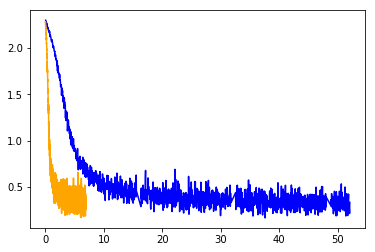

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(cpu_hist['dt'][:1500], cpu_hist['loss'][:1500], 'blue')
plt.plot(gpu_hist['dt'][:1500], gpu_hist['loss'][:1500], 'orange');

Notre implémentation d'EASGD synchrone, présentée dans [`pyzmq_tests/easgd_framework.ipynb`](https://github.com/NaasCraft/ELDTM/blob/master/pyzmq_tests/easgd_framework.ipynb), nous amène aux résultats suivants (on utilise $\alpha = 0.1$) :

In [3]:
gpu0_hist = pickle.load(open('pyzmq_tests/sml_gpu_0.pkl', 'rb'))
gpu1_hist = pickle.load(open('pyzmq_tests/sml_gpu_1.pkl', 'rb'))

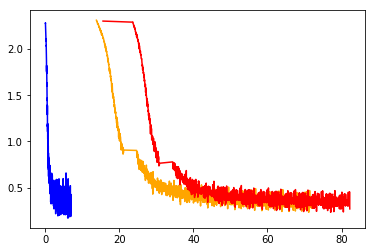

In [4]:
# SGD on 1 GPU : blue
plt.plot(gpu_hist['dt'][:1500], gpu_hist['loss'][:1500], 'blue')

# EASGD on 2 GPUs : gpu0 in red, gpu1 in orange
plt.plot(gpu1_hist['dt'][:1500], gpu1_hist['loss'][:1500], 'orange')
plt.plot(gpu0_hist['dt'][:1500], gpu0_hist['loss'][:1500], 'red');

Notre implémentation a un tel _overhead_ que le simple temps de lancement est supérieur au temps de convergence de SGD seul. Le décalage entre `gpu0` et `gpu1` s'explique par le fait que `gpu0` supporte simultanément les pilotes graphiques.

Mais les résultats sont encore pires sur CIFAR-10 : avec un cycle environ 1.5x fois plus long qu'avec une seule GPU, le gain en _throughput_ est faible, et la convergence n'est même pas encore entamée (on ne considère que 10 cycles pour l'expérience).

In [5]:
gpu0_cifar = pickle.load(open('pyzmq_tests/cifar_gpu_0.pkl', 'rb'))
gpu1_cifar = pickle.load(open('pyzmq_tests/cifar_gpu_1.pkl', 'rb'))

sgpu_cifar = pickle.load(open('cifar_sgpu.pkl', 'rb'))

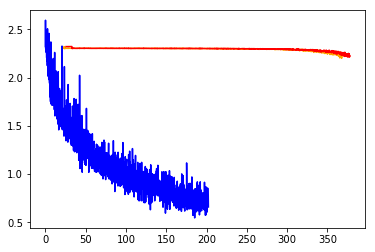

In [8]:
# SGD on 1 GPU
mint = min(sgpu_cifar['dt'])
dt_sgpu = [t - mint for t in sgpu_cifar['dt']]
plt.plot(dt_sgpu, sgpu_cifar['loss'], 'blue')

# EASGD on 2 GPUs
plt.plot(gpu1_cifar['dt'], gpu1_cifar['loss'], 'orange')
plt.plot(gpu0_cifar['dt'], gpu0_cifar['loss'], 'red');

# Conclusion

Bien que nous n'ayons pas eu le temps d'approfondir l'analyse de l'implémentation proposée, nous aurions souhaité :

+ Comparer les convergences pour différentes valeurs de $\eta \rho$ (nommé $\alpha$)
+ Implémenter la version asynchrone pour observer le gain de temps

Il nous semble probable que l'algorithme nécessite un ajustement précis, dépendant des données et du modèle utilisé. La non-convergence dans l'expérience avec CIFAR laisse néanmoins présager que le calibrage utilisé n'était clairement pas adapté à notre cas d'application.

Construire un framework multi-process avec communication via ZMQ était néanmoins une approche très intéressante. Exploiter `theano.shared` aurait été utile certainement...